<a href="https://colab.research.google.com/github/CS20M038/CS6910-assignment_3/blob/main/Assignment3_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

from scipy.ndimage.interpolation import shift
import csv
import random

In [2]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
input_characters =[' ']
target_characters = [' ']

In [4]:
input_dict=['-PAD-']
target_dict=['-PAD-']
eng_alphabets = 'abcdefghijklmnopqrstuvwxyz'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1
    input_dict.append(alpha)

print(eng_alpha2index)
print(input_dict)
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1
    target_dict.append(alpha)
    #print(alpha)

print(hindi_alpha2index)
print(target_dict)


# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_index2alpha = {0: pad_char}
for index, alpha in enumerate(hindi_alphabets):
    hindi_index2alpha[index+1] = alpha
   # target_dict.append(alpha)
    #print(alpha)

print(hindi_index2alpha)

eng_alphabets = 'abcdefghijklmnopqrstuvwxyz'
eng_index2alpha = {0: pad_char}
for index, alpha in enumerate(eng_alphabets):
    eng_index2alpha[index+1] = alpha
   # target_dict.append(alpha)
    #print(alpha)

print(eng_index2alpha)

{'-PAD-': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
['-PAD-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 6

In [5]:
def readXmlDataset(filename):
        tsv_file = open(filename)
        read_tsv = csv.reader(tsv_file, delimiter="\t")
        lang1_words = []
        lang2_words = []

        for row in read_tsv:
            lang2_words.append(row[0])
            lang1_words.append(row[1])
            #print(row[0])

        return lang1_words, lang2_words
train_input_texts, train_target_texts = readXmlDataset('hi.translit.sampled.train.tsv')
test_input_texts, test_target_texts = readXmlDataset('hi.translit.sampled.test.tsv')

In [6]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = np.zeros((len(word)+1,  129))
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][pad_pos] = 1
    return rep

def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = np.zeros([len(word)+1, 1], dtype=np.long)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep
    word_rep('abc',eng_alpha2index).shape
    x=gt_rep('abc',eng_alpha2index)

In [7]:
def createDataset(dataset,letter2index):
    X_train=[]
    for i,data in enumerate(dataset):
        #print(data)
        X_train.append(word_rep(data,letter2index))
    X_train = np.array(X_train)
    return X_train

In [8]:
X_train = createDataset(train_input_texts,eng_alpha2index)
y_train = createDataset(train_target_texts,hindi_alpha2index)
X_test = createDataset(test_input_texts,eng_alpha2index)
y_test = createDataset(test_target_texts,hindi_alpha2index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [9]:
print(len(eng_alpha2index))
#a=[0]*(len(eng_alpha2index)-1)
a=[0]*128
eng_pad=[1]
eng_pad=eng_pad+a
print(eng_pad)
print(len(hindi_alpha2index))
a=[0]*128
hindi_pad=[1]
hindi_pad=hindi_pad+a
print(hindi_pad)

27
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
129
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

In [11]:
one_hot_encode([1,2,3],10)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [12]:
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]
'''d=one_hot_decode(y_train_padded[5])
c=hindi_index2alpha[6]+hindi_index2alpha[3]+hindi_index2alpha[22]+hindi_index2alpha[66]+hindi_index2alpha[49]+hindi_index2alpha[64]+hindi_index2alpha[37]+hindi_index2alpha[0]
c'''

'd=one_hot_decode(y_train_padded[5])\nc=hindi_index2alpha[6]+hindi_index2alpha[3]+hindi_index2alpha[22]+hindi_index2alpha[66]+hindi_index2alpha[49]+hindi_index2alpha[64]+hindi_index2alpha[37]+hindi_index2alpha[0]\nc'

In [13]:
max_input_sequence= max(len(seq) for seq in X_train)
max_output_sequence= max(len(seq) for seq in y_train)

print('max_input_sequence: ', max_input_sequence)
print('max_output_sequence: ', max_output_sequence)

max_input_sequence:  21
max_output_sequence:  20


In [14]:
from keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(X_train, maxlen= max_input_sequence, padding='post', value=eng_pad)
print("X_train shape: ",X_train.shape)
print("X_train_padded shape: ",X_train_padded.shape)

y_train_padded = pad_sequences(y_train, maxlen= max_output_sequence, padding='post', value=hindi_pad)
print("y_train shape: ",y_train.shape)
print("y_train_padded shape: ",y_train_padded.shape)

X_train shape:  (44204,)
X_train_padded shape:  (44204, 21, 129)
y_train shape:  (44204,)
y_train_padded shape:  (44204, 20, 129)


In [15]:
i=0
print("____Sample Input (Raw Format)____")
print("Original:\n", one_hot_decode(X_train[i]))
print("Padded:\n",one_hot_decode(X_train_padded[i]))
print("____Corresponding Output (Raw Format)____")
print("Original:\n", one_hot_decode(y_train[i]))
print("Padded:\n",one_hot_decode(y_train_padded[i]))

____Sample Input (Raw Format)____
Original:
 [1, 14, 0]
Padded:
 [1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
____Corresponding Output (Raw Format)____
Original:
 [6, 3, 0]
Padded:
 [6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
X_test_padded = pad_sequences(X_test, maxlen= max_input_sequence, padding='post', 
                              value=eng_pad)
print("X_test shape: ",X_test.shape)
print("X_test_padded shape: ",X_test_padded.shape)

y_test_padded = pad_sequences(y_test, maxlen= max_output_sequence, padding='post', 
                              value=hindi_pad)
print("y_test shape: ",y_test.shape)
print("y_test_padded shape: ",y_test_padded.shape)

X_test shape:  (4502,)
X_test_padded shape:  (4502, 21, 129)
y_test shape:  (4502,)
y_test_padded shape:  (4502, 20, 129)


In [17]:
#Prepare TRAIN data set
input_dimension = len(hindi_alpha2index)   #@param {type:"integer"}
encoder_input_data = X_train_padded.copy()
decoder_target_data = y_train_padded.copy()
decoder_input_data = decoder_target_data.copy()
for i, samples in enumerate(decoder_target_data):
  seq = one_hot_decode(samples)
  shifted= shift(seq, 1, cval=0)
  decoder_input_data[i]=one_hot_encode(shifted,input_dimension)
print("Data for Train")
print('encoder_input_data (X): ', one_hot_decode(encoder_input_data[1]))
print('decoder_input_data (teacher forcing): ',one_hot_decode(decoder_input_data[1]))
print('decoder_target_data (y):',one_hot_decode(decoder_target_data[1]))
print(encoder_input_data.shape)

#Prepare TEST data set
encoder_input_test = X_test_padded.copy()
decoder_target_test = y_test_padded.copy()
decoder_input_test= decoder_target_test.copy()
for i, samples in enumerate(decoder_target_test):
  seq = one_hot_decode(samples)
  shifted= shift(seq, 1, cval=0)
  decoder_input_test[i]=one_hot_encode(shifted,input_dimension)

Data for Train
encoder_input_data (X):  [1, 14, 11, 7, 1, 14, 9, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
decoder_input_data (teacher forcing):  [0, 6, 3, 22, 24, 36, 64, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
decoder_target_data (y): [6, 3, 22, 24, 36, 64, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(44204, 21, 129)


In [18]:
#@title LSTMoutputDimension
LSTMoutputDimension = 256 #@param {type:"integer"}

In [19]:
# Define an input sequence and process it.
encoder_inputs= Input(shape=(max_input_sequence, input_dimension), name='encoder_inputs')

masking = tf.keras.layers.Masking(mask_value= hindi_pad)
encoder_inputs_masked = masking(encoder_inputs)


encoder_lstm=LSTM(LSTMoutputDimension, return_state=True, name='encoder_lstm')
LSTM_outputs, state_h, state_c = encoder_lstm(encoder_inputs_masked)


# We discard `LSTM_outputs` and only keep the other states.
encoder_states = [state_h, state_c]



decoder_inputs = Input(shape=(None, input_dimension), name='decoder_inputs')
decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm')

# Set up the decoder, using `context vector` as initial state.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

#complete the decoder model by adding a Dense layer with Softmax activation function 
#for prediction of the next output
#Dense layer will output one-hot encoded representation as we did for input
#Therefore, we will use input_dimension number of neurons
decoder_dense = Dense(input_dimension, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# put together
model_encoder_training = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='model_encoder_training')

Model: "model_encoder_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 21, 129)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 21, 129)      0           encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 129)]  0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 395264      masking[0][0]                    
_____________________________________________________________________________

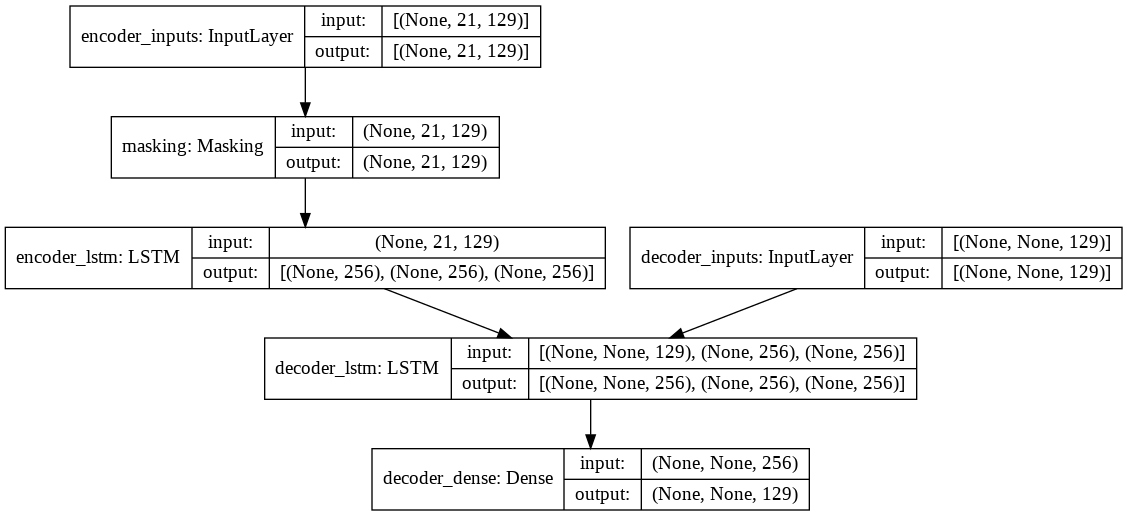

In [78]:
model_encoder_training.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_encoder_training.summary()
plot_model(model_encoder_training, show_shapes=True)

In [79]:
model_encoder_training.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=100,
          validation_split=0.2)

Epoch 1/100
553/553 [==============================] - 26s 37ms/step - loss: 0.0110 - accuracy: 0.9956 - val_loss: 0.3877 - val_accuracy: 0.9349
Epoch 2/100
553/553 [==============================] - 19s 33ms/step - loss: 0.0119 - accuracy: 0.9951 - val_loss: 0.3873 - val_accuracy: 0.9348
Epoch 3/100
553/553 [==============================] - 18s 33ms/step - loss: 0.0109 - accuracy: 0.9954 - val_loss: 0.3931 - val_accuracy: 0.9334
Epoch 4/100
553/553 [==============================] - 19s 34ms/step - loss: 0.0102 - accuracy: 0.9955 - val_loss: 0.3708 - val_accuracy: 0.9358
Epoch 5/100
553/553 [==============================] - 19s 33ms/step - loss: 0.0096 - accuracy: 0.9958 - val_loss: 0.3822 - val_accuracy: 0.9341
Epoch 6/100
553/553 [==============================] - 18s 33ms/step - loss: 0.0101 - accuracy: 0.9957 - val_loss: 0.3783 - val_accuracy: 0.9341
Epoch 7/100
553/553 [==============================] - 19s 33ms/step - loss: 0.0105 - accuracy: 0.9957 - val_loss: 0.3844 - val_ac

In [71]:
def printTargetWord(seq):
    word = ""
    for chr in seq:
        #print(chr)
        if chr == 0:
            break
        word=word+hindi_index2alpha[int(chr)]
    return word
def printInputWord(seq):
    word = ""
    for chr in seq:
        if chr==0:
            break
        word=word+eng_index2alpha[int(chr)]
    return word

In [69]:
printInputWord([1, 14, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'ank'

In [76]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  100

	predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( printInputWord(one_hot_decode(X_test[0][sample])), ' ', 
					printTargetWord(one_hot_decode(y_test[sample])),' ', printTargetWord(one_hot_decode(predicted[sample])),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)

training for  55  epochs begins with EarlyStopping(monitor= val_loss, patience= 3 )....
Epoch 1/55
622/622 - 13s - loss: 0.0118 - accuracy: 0.9953 - val_loss: 0.7372 - val_accuracy: 0.8773
Epoch 2/55
622/622 - 13s - loss: 0.0118 - accuracy: 0.9953 - val_loss: 0.7484 - val_accuracy: 0.8757
Epoch 3/55
622/622 - 13s - loss: 0.0118 - accuracy: 0.9953 - val_loss: 0.7687 - val_accuracy: 0.8725
Epoch 4/55
622/622 - 13s - loss: 0.0117 - accuracy: 0.9952 - val_loss: 0.7657 - val_accuracy: 0.8752
Epoch 00004: early stopping
55  epoch training finished...

PREDICTION ACCURACY (%):
Train: 98.444, Test: 93.498


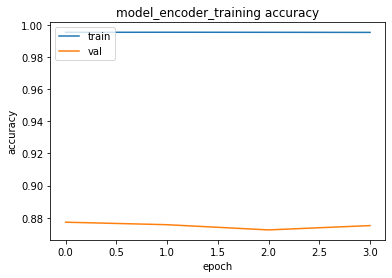

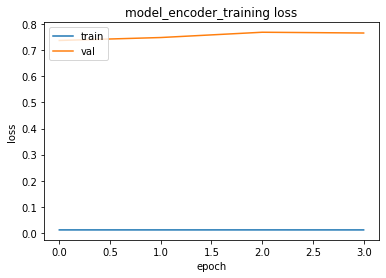

10 examples from test data...
Input                                                          Expected                                                       Predicted                                                         T/F
ank   अंक   अंक   True
anka   अंक   अनका   False
ankit   अंकित   अंकित   True
anakon   अंकों   अनकों   False
ankhon   अंकों   अँखखह   False
ankon   अंकों   आनकों   False
angkor   अंकोर   अंगगरो   False
ankor   अंकोर   अंकोर   True
angaarak   अंगारक   अंगारक   True
angarak   अंगारक   अंगररक   False
angraji   अंग्रज़ी   अंग्रजीी   False
angreji   अंग्रज़ी   अंग्रेीी   False
angrzi   अंग्रज़ी   आंग्रजीी   False
antah   अंतः   अंतह   False
antaha   अंतः   अंतहा   False
antarmukh   अंतर्मुख   अंतरुमुख   False
antmurkh   अंतर्मुख   अंतरुमु   False
antrmukh   अंतर्मुख   अंतरुमुख   False
andrabee   अंद्राबी   अंदरराईी   False
andrabi   अंद्राबी   अंदरराणी   False
andha   अंधा   अंधा   True
andhapan   अंधापन   अंधापन   True
andheri   अंधेरी   एंधेरी   False
ambaani   अंबान

In [77]:
train_test(model_encoder_training, [encoder_input_data, decoder_input_data], decoder_target_data ,
           [encoder_input_test, decoder_input_test], 
           decoder_target_test, epochs=55, batch_size=64, patience=3,verbose=2)

In [27]:
encoder_model = Model(encoder_inputs, encoder_states)

In [28]:
decoder_state_input_h = Input(shape=(LSTMoutputDimension,))
decoder_state_input_c = Input(shape=(LSTMoutputDimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [29]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, input_dimension))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1 
    # START (0 zero) in one-hot-encoding --> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_char)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 0 or
           len(decoded_seq) == max_output_sequence):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq = np.zeros((1, 1, input_dimension))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq

In [ ]:
print('Input \t\t\t\t\t  Expected  \t\t\t   Predicted \t\t\t\t\t\t\t T/F')
correct =0 
sampleNo =  1000
for sample in range(0,sampleNo):
  predicted= decode_sequence(encoder_input_data[sample].reshape(1,max_input_sequence,input_dimension))
  if (one_hot_decode(decoder_target_data[sample])== predicted+ [0] * (max_output_sequence- len(predicted))):
    correct+=1
  print( one_hot_decode(encoder_input_data[sample]), '\t\t', 
        one_hot_decode(decoder_target_data[sample]),'\t', predicted,
        '\t\t',one_hot_decode(decoder_target_data[sample])== predicted+ [0] * (max_output_sequence- len(predicted)))
print('Accuracy: ', correct/sampleNo)

In [69]:
print(encoder_input_data[2].shape)
encoder_test_word_input_data[2].shape

(21, 129)


(21, 129)

In [91]:
w="abc"
w=w.rstrip(w[-1])
print(w)

ab


In [100]:
test_word_set = ['kamal']
X_test_word=createDataset(test_word_set,eng_alpha2index)
X_test_word_padded=pad_sequences(X_test_word, maxlen= max_input_sequence, padding='post', value=eng_pad)
print("X_test_word shape: ",X_test_word.shape)
print("X_test_word_padded shape: ",X_test_word_padded.shape)
encoder_test_word_input_data = X_test_word_padded.copy()
decode_seq= decode_sequence(encoder_test_word_input_data[0].reshape(1,max_input_sequence,input_dimension))
print(decode_seq)
printTargetWord(decode_seq[:-1])


X_test_word shape:  (1, 6, 129)
X_test_word_padded shape:  (1, 21, 129)
[22, 47, 51, 0]


'कमल'

In [41]:
randomlist = []
for i in range(0,10):
    n = random.randint(100,1000)
    randomlist.append(n)
print(randomlist)
for seq_index in randomlist:
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_test[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    #print("Input sentence:", input_texts[seq_index])
    print("Input sentence:", train_input_texts[seq_index])
    print("Decoded sentence:", printTargetWord(decoded_sentence))

[658, 109, 711, 655, 266, 429, 938, 229, 115, 644]
-
Input sentence: adhikarhin
Decoded sentence: कंपोसर-PAD-
-
Input sentence: antrikshyatri
Decoded sentence: अनुदित-PAD-
-
Input sentence: adhishthan
Decoded sentence: कामतार-PAD-
-
Input sentence: adhikarsheter
Decoded sentence: कंटेपमरे-PAD-
-
Input sentence: akeli
Decoded sentence: आगमान-PAD-
-
Input sentence: ajanta
Decoded sentence: वेइनिंग-PAD-
-
Input sentence: anupalabdh
Decoded sentence: खींचाकर-PAD-
-
Input sentence: karmnyata
Decoded sentence: अष्टकता-PAD-
-
Input sentence: antaron
Decoded sentence: अपरिवर्तनशील-PAD-
-
Input sentence: adhikaansh
Decoded sentence: औद्योगिकारान-PAD-


In [37]:
seq=[2,4,5]
printTargetWord(seq)

'ँःऄ'

In [81]:

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


In [82]:

# load text
raw_text = load_doc('rhyme.txt')
print(raw_text)



Sing a song of sixpence,
A pocket full of rye.
Four and twenty blackbirds,
Baked in a pie.
 
When the pie was opened
The birds began to sing;
Wasn't that a dainty dish,
To set before the king.
 
The king was in his counting house,
Counting out his money;
The queen was in the parlour,
Eating bread and honey.
 
The maid was in the garden,
Hanging out the clothes,
When down came a blackbird
And pecked off her nose.


In [83]:
# clean
tokens = raw_text.split()
raw_text = ' '.join(tokens)

In [85]:
raw_text

"Sing a song of sixpence, A pocket full of rye. Four and twenty blackbirds, Baked in a pie. When the pie was opened The birds began to sing; Wasn't that a dainty dish, To set before the king. The king was in his counting house, Counting out his money; The queen was in the parlour, Eating bread and honey. The maid was in the garden, Hanging out the clothes, When down came a blackbird And pecked off her nose."

In [89]:
length = 10
sequences = list()
for i in range(length, len(raw_text)):
    # select sequence of tokens
	seq = raw_text[i-length:i+1]
    print(seq)
	sequences.append(seq)
print('Total Sequences: %d' % len(sequences))

IndentationError: ignored

In [91]:
length = 10
sequences = list()
for i in range(length, len(raw_text)):
    seq = raw_text[i-length:i+1]
    print(seq)
    sequences.append(seq)
print('Total Sequences: %d' % len(sequences))



Sing a song
ing a song 
ng a song o
g a song of
 a song of 
a song of s
 song of si
song of six
ong of sixp
ng of sixpe
g of sixpen
 of sixpenc
of sixpence
f sixpence,
 sixpence, 
sixpence, A
ixpence, A 
xpence, A p
pence, A po
ence, A poc
nce, A pock
ce, A pocke
e, A pocket
, A pocket 
 A pocket f
A pocket fu
 pocket ful
pocket full
ocket full 
cket full o
ket full of
et full of 
t full of r
 full of ry
full of rye
ull of rye.
ll of rye. 
l of rye. F
 of rye. Fo
of rye. Fou
f rye. Four
 rye. Four 
rye. Four a
ye. Four an
e. Four and
. Four and 
 Four and t
Four and tw
our and twe
ur and twen
r and twent
 and twenty
and twenty 
nd twenty b
d twenty bl
 twenty bla
twenty blac
wenty black
enty blackb
nty blackbi
ty blackbir
y blackbird
 blackbirds
blackbirds,
lackbirds, 
ackbirds, B
ckbirds, Ba
kbirds, Bak
birds, Bake
irds, Baked
rds, Baked 
ds, Baked i
s, Baked in
, Baked in 
 Baked in a
Baked in a 
aked in a p
ked in a pi
ed in a pie
d in a pie.
 in a pie. 
in a pie. W
n a pie. Wh
 a p

In [92]:
def save_doc(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()